In [5]:
import pandas as pd
import re
import os
import datetime
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
from nltk.stem.snowball import SnowballStemmer
# from PIL import Image
# from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

stopwords=[u'и',u'в',u'во',u'что',u'он',u'на',u'я',u'с',u'со',u'как',u'а',u'то',u'все',u'она',u'так',u'его',u'но',u'да',u'ты',u'к',u'у',u'же',
u'за',u'бы',u'по',u'только',u'ее',u'мне',u'было',u'вот',u'от',u'меня',u'еще', u'о',u'из',u'ему',u'теперь',u'когда',u'даже',u'ну',u'вдруг',
u'ли',u'если',u'уже',u'или',u'ни',u'быть',u'был',u'него',u'до',u'вас',u'нибудь',u'опять',u'уж',u'вам',u'ведь',u'там',u'потом',u'себя',u'ничего',
u'ей',u'может',u'они',u'тут',u'где',u'есть',u'надо',u'ней',u'для',u'мы',u'тебя',u'их',u'чем',u'была',u'сам',u'чтоб',u'без',u'будто',u'чего',u'раз',
u'тоже',u'себе',u'под',u'будет',u'ж',u'тогда',u'кто',u'этот',u'того',u'потому',u'этого',u'какой',u'совсем',u'ним',u'здесь',u'этом',u'один',u'почти',u'мой',
u'тем',u'чтобы', u'rur', u'rub', u'ru', u'руб', u'рублей', u'ндс', u'ooo', u'oao', u'без', u'ао', u'зао', u'г', u'ы', u'пао', u'гуп', u'ук',
u'кпк', u'кх', u'бст', u'хк', u'ук', u'январь', u'февраль', u'март',u'апрель',u'май', u'июнь', u'июль', u'август', u'сентябрь', u'октябрь', u'ноябрь', u'декабрь',
u'июл', u'феврал', u'распоряжение', u'облагается', u'n',  u'шт', u'период', u'г', u'eur', u'маы', u'апрел', u'июн', u'январ', u'иуне',
u'иуле', u'дог', u'рублях', u'начисление', u'экз',  u'sd', u'возврат', u'взимание', u'ед', u'е', u'юр', u'а',u'б',u'в',u'г',u'д',u'е',u'ё',
u'ж',u'з',u'и',u'к',u'л',u'м',u'н',u'о',u'п',u'р',u'с',u'т',u'у',u'ф',u'х',u'ц',u'ч',u'ш',u'щ',u'ъ',u'ы',u'ь',u'э',u'ю',u'я', u'р', u'б', u'н', u'нал', u'сч',
u'запрос', u'ип', u'монеты', u'дс', u'бум', u'лоро', u'заявке', u'нальчик', 'a','b','v','g','d','e','e','zh','z','i','k','l','m','n','o','p','r','s','t','u','f','h',
u'вал', u' подразд', u'приема', u'см', u'usd', u'sek', u'nok',  u'орому', u'орым', u'lc', u'usd', u'ов', u'vo', u'осб', u'сзб', u'visa', u'mastercard', u'тс',
u'ммвб', u'фб', u'дату', u'инн', u'кпп', u'ко', u'пс', u'контр', u'кампания', u'бух', u'ген', u'дир', u'кампании', u'через', u'над', u'ксб', u'скб', u'над',
u'списание', u'согл', u'распоряжению', u'свыше', u'виза', u'дог', u'файл', u'spe', u'spx', u'spdz', u'января',u'февраля', u'марта', u'апреля', u'мая', u'июня', u'июля', u'августа', u'сентября',
u'октября', u'ноября', u'декабря', u'зао', u'ооо', u'оао', u'ао', u'без', u'пао', u'гуп', u'ук', u'кпк', u'кх', u'бст', u'хк']

In [8]:
def create_new_directory(name):
    if not os.path.exists(name):
            os.mkdir(name)
            
def delete_punctuation(s):
    return ' '.join((re.sub(r'[№"\'-_/.:?!1234567890()%<>;,+#$&\s+]', u' ', s)).split())

def delete_stopwords(s):
    return ' '.join([word for word in (re.sub(r'[()\s+]', u' ', s)).split() if word not in stopwords])

def get_campaign():
    start_time=datetime.datetime.now()
    con=cx_Oracle.connect('iskra/iskraurskb@iskra1_cskostat')
    query=  "select distinct pl_id_k_in_crm from( "\
            "select/*+ RESULT_CACHE*/ "\
                "case when pl_id_k_in_crm like '%ЦА%ЗП%ФОТ%' then "\
                "pl_id_k_in_crm || ' (ПИРС)' "\
             "else pl_id_k_in_crm end pl_id_k_in_crm, "\
             "pl_num_id, date_load, pl_status, pl_brand_com, pl_main_chanal "\
             "from atb_segmen_kp_pl)"
    print(query)
    data=pd.read_sql(query, con=con)
    print("End extracting data: "+ str(datetime.datetime.now()-start_time))
    return data

def get_data(campaign_name):
    start_time=datetime.datetime.now()
    con=cx_Oracle.connect('iskra/iskraurskb@iskra1_cskostat')
    query="select REGEXP_REPLACE(ltrim(REGEXP_REPLACE(TEXT, '[[:digit:]|[:punct:]]+', \' \'), \' \'), \'( ){2,}\', \' \') TEXT "\
          "from ( select  /*+ parallel(32)*/ lower(TO_CHAR(SUBSTR(tasks_comment,0, DBMS_LOB.getlength(tasks_comment)))) TEXT "\
          "from atb_segmen_tasks_kamp where status = 'Закрыта' and tasks_comment is not null and date_load='15.12.2017' and CAMPAIGN_ID_ZADACHA like '%"+campaign_name+"%')"
    print(query)
    data=pd.read_sql(query, con=con)
    print("End extracting data: "+ str(datetime.datetime.now()-start_time))
    return data

def get_stat(data, filename):
    df=pd.DataFrame()
    for cls in list(data['class'].drop_duplicates()):
        data_split=data[data['class']==cls]
        df=df.append([[cls, data_split['class'].count()]])
    df.columns=['class', 'count']
    df.to_csv(filename+'_stat.csv', sep=';')
    
    
    
def cut_words_freq(words_freq):
    # для того, чтобы свернуть похожие ключевые слова
    keys=list(words_freq.keys())
    for word in keys:
        if word in words_freq.keys():
            stemmed_word=stemmer.stem(word) 
            similar_keys=[s for s in words_freq.keys() if stemmed_word in s]

            similar_word_freq={}
            for similar_key in similar_keys:
                similar_word_freq[similar_key]=words_freq[similar_key]   
            if len(similar_word_freq)!=0:
                word_max=max(similar_word_freq, key=similar_word_freq.get)

                for key in similar_keys:
                    if word_max !=key:
                        words_freq[word_max]+=words_freq[key]
                        words_freq.pop(key)
                        
    return words_freq

def get_cloud(count_words, data, filename, flag=0):
    cloud_mask=np.array(Image.open("cloud form.png"))
    fig=plt.figure(figsize=(45,30))
    wordcloud=WordCloud(collocations=False, background_color="white", mask=cloud_mask, stopwords=stopwords, max_words=count_words)   
    wordcloud.generate_from_frequencies(frequencies=data)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()      
    fig.savefig(filename+'.png') 
    if flag==1:
        return wordcloud
       
def collect(x):
    for s in x.split(' '):
        if (len(s)<4) & (s not in collection) & (s not in ['нет', 'не', 'др']):
            collection.append(s)
            
def get_colors():
    colors=list(matplotlib.colors.cnames.keys())
    colors=colors[::2] 
    len(colors)
    return colors

def get_color_big_class():
    classes=pd.read_excel('Все кластеры.xlsx', encoding='cp1251')
    hierach_classes={}
    for cls, big_cls in zip(classes['Кластер - 2'], classes['Кластер - 1']):
        hierach_classes[cls]=big_cls
    neg_pos_color_big_cls={'Встреча': 'green',
                           'Выполнено': 'green',
                           'Неудачный контакт': 'grey',
                           'Отказ': 'red',
                           'Ошибка задачи': 'grey',
                           'Перспектива': 'green',
                           'Проблемный клиент': 'red',
                           'Условия': 'red'}
    
    neg_pos_color_small_cls={}
    for key in neg_pos_color_big_cls.keys():
        if neg_pos_color_big_cls[key] in neg_pos_color_small_cls.keys():
            neg_pos_color_small_cls[neg_pos_color_big_cls[key]]=neg_pos_color_small_cls[neg_pos_color_big_cls[key]]+(list(classes[classes['Кластер - 1']==key]['Кластер - 2'].values))
        else:
            neg_pos_color_small_cls[neg_pos_color_big_cls[key]]=list(classes[classes['Кластер - 1']==key]['Кластер - 2'].values)
    print(neg_pos_color_small_cls)  
    
    small_cls={}
    for key in neg_pos_color_small_cls.keys():
        for values in neg_pos_color_small_cls[key]:
            small_cls[values]=key
    return small_cls

In [ ]:

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.
       Uses wordcloud.get_single_color_func
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [207]:
campaigns=pd.read_excel('count компаний продаж.xlsx', encoding='cp1251')
campaigns=campaigns['CAMPAIGN_ID_ZADACHA'].values[:10]
campaigns=[ 'ЦА-ЕДНБАЗММБЦКР-1117', 'ЦА-ПРОДММБ-0117' ]

select distinct pl_id_k_in_crm from( select/*+ RESULT_CACHE*/ case when pl_id_k_in_crm like '%ЦА%ЗП%ФОТ%' then pl_id_k_in_crm || ' (ПИРС)' else pl_id_k_in_crm end pl_id_k_in_crm, pl_num_id, date_load, pl_status, pl_brand_com, pl_main_chanal from atb_segmen_kp_pl)
End extracting data: 0:00:01.562000
Clustering with k-means (2 clusters) ... 
Clustering with k-means (3 clusters) ... 
Clustering with k-means (4 clusters) ... 
Clustering with k-means (5 clusters) ... 
Clustering with k-means (6 clusters) ... 
Clustering with k-means (7 clusters) ... 
Clustering with k-means (8 clusters) ... 
Clustering with k-means (9 clusters) ... 
Clustering with k-means (10 clusters) ... 
Clustering with k-means (11 clusters) ... 
Clustering with k-means (12 clusters) ... 
Clustering with k-means (13 clusters) ... 
Clustering with k-means (14 clusters) ... 
Clustering with k-means (15 clusters) ... 
Clustering with k-means (16 clusters) ... 
Clustering with k-means (17 clusters) ... 
Clustering with k-me

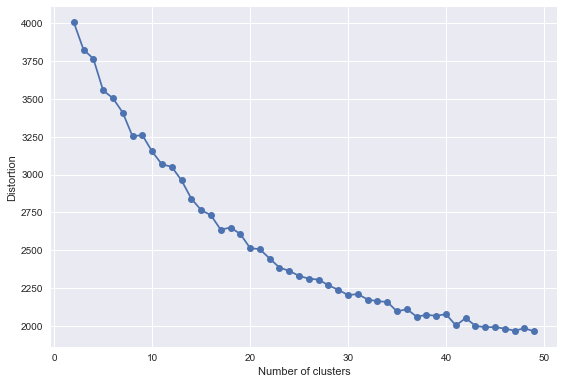

In [41]:
from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import seaborn as sns

campaigns=get_campaign()
campaigns=campaigns.dropna()
campaigns['PL_ID_K_IN_CRM']=campaigns['PL_ID_K_IN_CRM'].apply(lambda x: delete_punctuation(x))
vectorizer=CountVectorizer()
vectors=vectorizer.fit_transform(campaigns['PL_ID_K_IN_CRM'].values)
#https://github.com/glebmikha/ipython_notebooks/blob/master/wine_dataset.ipynb
distortions = []
for i in range(2, 50):
    print('Clustering with k-means (%d clusters) ... \n' %(i), end='', flush=True)
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=15, 
                random_state=48)
   
    km.fit(vectors)
    distortions.append(km.inertia_)
plt.plot(range(2, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

In [18]:
#load
digit_class=joblib.load('declasses_dict.pkl')
classifier=joblib.load('clf_done.pkl')

#Получение актуального списка компаний
# campaigns=get_campaign()
# campaigns=campaigns.dropna()
# print(campaigns.shape[0])
# campaigns=campaigns['PL_ID_K_IN_CRM'].values
# for campaign in campaigns:
campaign='ЦА-ПРОДММБ-0117'
collection=[]
create_new_directory(campaign)
data=pd.read_csv('data\\test.csv', delimiter=';', encoding='cp1251')
print(campaign +': '+str(data.shape[0]))
data=data.dropna()
data['TEXT'].apply(lambda x: collect(x))
stopwords=stopwords+collection

data['TEXT']=data['TEXT'].apply(lambda x: delete_stopwords(x))
data['TEXT']=data['TEXT'].apply(lambda x: x.replace('не ', 'не_').replace('нет ', 'нет_').replace('др ', 'др_'))
data['class']= classifier.predict(data['TEXT'].values)
data['class']=data['class'].apply(lambda x: digit_class[x])
data=data[data['class']!='мусор']
data.to_csv(campaign+'\\'+campaign+'.csv', sep=';')
get_stat(data, campaign+'\\'+campaign)

#Отрисовка облаков
stemmer=SnowballStemmer("russian")    
group_words={}
df=pd.DataFrame()
for cls in list(data['class'].drop_duplicates()):
    data_split=data[data['class']==cls]

    vectorizer=CountVectorizer(max_features=30)
    counts = vectorizer.fit_transform(data_split['TEXT']).toarray().sum(axis=0)                                               
    words = vectorizer.get_feature_names()    
#     print(cls)
#     print(words)

    words_freq={}
    for word, count in zip(words, counts):
        words_freq[word]=count
    words_freq=cut_words_freq(words_freq)  
    df=df.append([[cls, list(words_freq.keys()) ]], ignore_index=True)
    group_words[cls]=words_freq

#     create_new_directory(campaign+'\\clouds\\')
#     get_cloud(10, words_freq, campaign+'\\clouds\\'+cls.replace('\\', '.'))
df
# all_words={}
# for lst in list(group_words.values()):
#     all_words.update(lst)

# cloud=get_cloud(200, all_words, 'all', 1)

# class_colors=get_color_big_class()
# colored_words={}
# keys=list(group_words.keys())
# for key in keys:
#     if key=='мусор':
#         continue
#     if class_colors[key] in colored_words:
#         colored_words[class_colors[key]]= colored_words[class_colors[key]]+list(group_words[key])
#     else:
#         colored_words[class_colors[key]]=list(group_words[key])

#         default_color='grey'
# grouped_color_func = GroupedColorFunc(colored_words, default_color)
# cloud.recolor(color_func=grouped_color_func)
# fig=plt.figure(figsize=(45,30))
# plt.imshow(cloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# fig.savefig(campaign+'\\clouds\\all_colored.png')   


ЦА-ПРОДММБ-0117: 19855


0  \
0                       встреча   
1                         отказ   
2                        звонок   
3              род деятельности   
4                    не лоялен    
5                территориально   
6         не ведет деятельность   
7   не соответсвует требованиям   
8                    интересует   
9                   безналичный   
10                нет контактов   
11   не нужен\не может\не хочет   
12           клиент согласен на   
13                      сегмент   
14                др продукт сб   
15                       сделка   
16                 надежда есть   
17                    документы   
18         отказ категорический   
19                      др банк   
20                         пока   
21    не отработана. перенесена   
22                   переговоры   
23                  не ответили   
24                  есть кредит   
25             не разговаривают   
26               дорогие тарифы   
27            небольшие обороты   
28                    выполнено   
29                   ликвидация   
..                          ...   
35             много документов   
36                       занято   
37                     проблемы   
38                  голов. комп   
39                           км   
40                    подключен   
41                  счет закрыт   
42              группа компаний   
43                придет в банк   
44              сезонный бизнес   
45                 нет на месте   
46                реорганизация   
47           приглашение в банк   
48                      погашен   
49                        дубль   
50                    счет есть   
51                  черная зона   
52                      возраст   
53          рассчитан овердрафт   
54     планируют закрывать счет   
55                  банкротство   
56                           фл   
57                      условия   
58            не рассчитывается   
59            досрочное гашение   
60               казн. + бюджет   
61               кэптивный банк   
62                    просрочка   
63             реструктуризация   
64    отказ от реструктуризации   

                                                    1  
0   [проведена, место, после, предварительно, пере...  
1   [отказ, предложение, время, страхование, перег...  
2   [время, предложение, договорились, телефон, се...  
3   [работами, клиента, не_актуален, предложение, ...  
4   [отказ, средств, предложение, против, сбербанк...  
5   [территориально, переговоры, счет, сейчас, ком...  
6   [отказ, деятельности, банка, пока, счет, эквай...  
7   [отказ, задолженность, операций, требованиям, ...  
8   [отказ, время, переговоры, встреча, след, кред...  
9   [место, предложение, отказ, компании, продукты...  
10  [клиента, номер, предложение, телефон, компани...  
11  [время, переговоры, сейчас, встреча, собственн...  
12  [каких, предложение, согласен, продукты, слов,...  
13  [не_можем, деятельности, относится, средний, в...  
14  [предложение, клиента, компании, продукты, сло...  
15  [средств, сделка, переговоры, сбор, заведена, ...  
16  [после, кредитованию, конце, компании, условий...  
17  [запрошены, переговоры, договорились, залог, в...  
18  [продуктов, отказ, переговоры, категорический,...  
19  [отказ, основные, спарк, компании, продукты, к...  
20  [банка, средств, не_интересны, переговоры, вст...  
21  [план, продуктов, кредитованию, предложение, п...  
22  [проводились, нет_необходимости, кредитованию,...  
23  [номеру, банке, отвечает, телефон, несколько, ...  
24  [сумму, рамках, пока, декабре, выдан, ранее, н...  
25  [отказ, время, спарк, трубку, договорились, ск...  
26  [отказ, деят, банке, комментарии, встреча, ста...  
27  [место, ведения, средств, собственных, оборот,...  
28  [проведена, рамках, выполнено, принята, пока, ...  
29  [место, отказ, счет, деятельности, ликвидации,...  
..                                                ...  
35  [отказ, сейчас, сложный, стороннем, организаци...  
36  [директ

In [19]:
df.to_csv('key_words.csv', sep=';', encoding='cp1251')

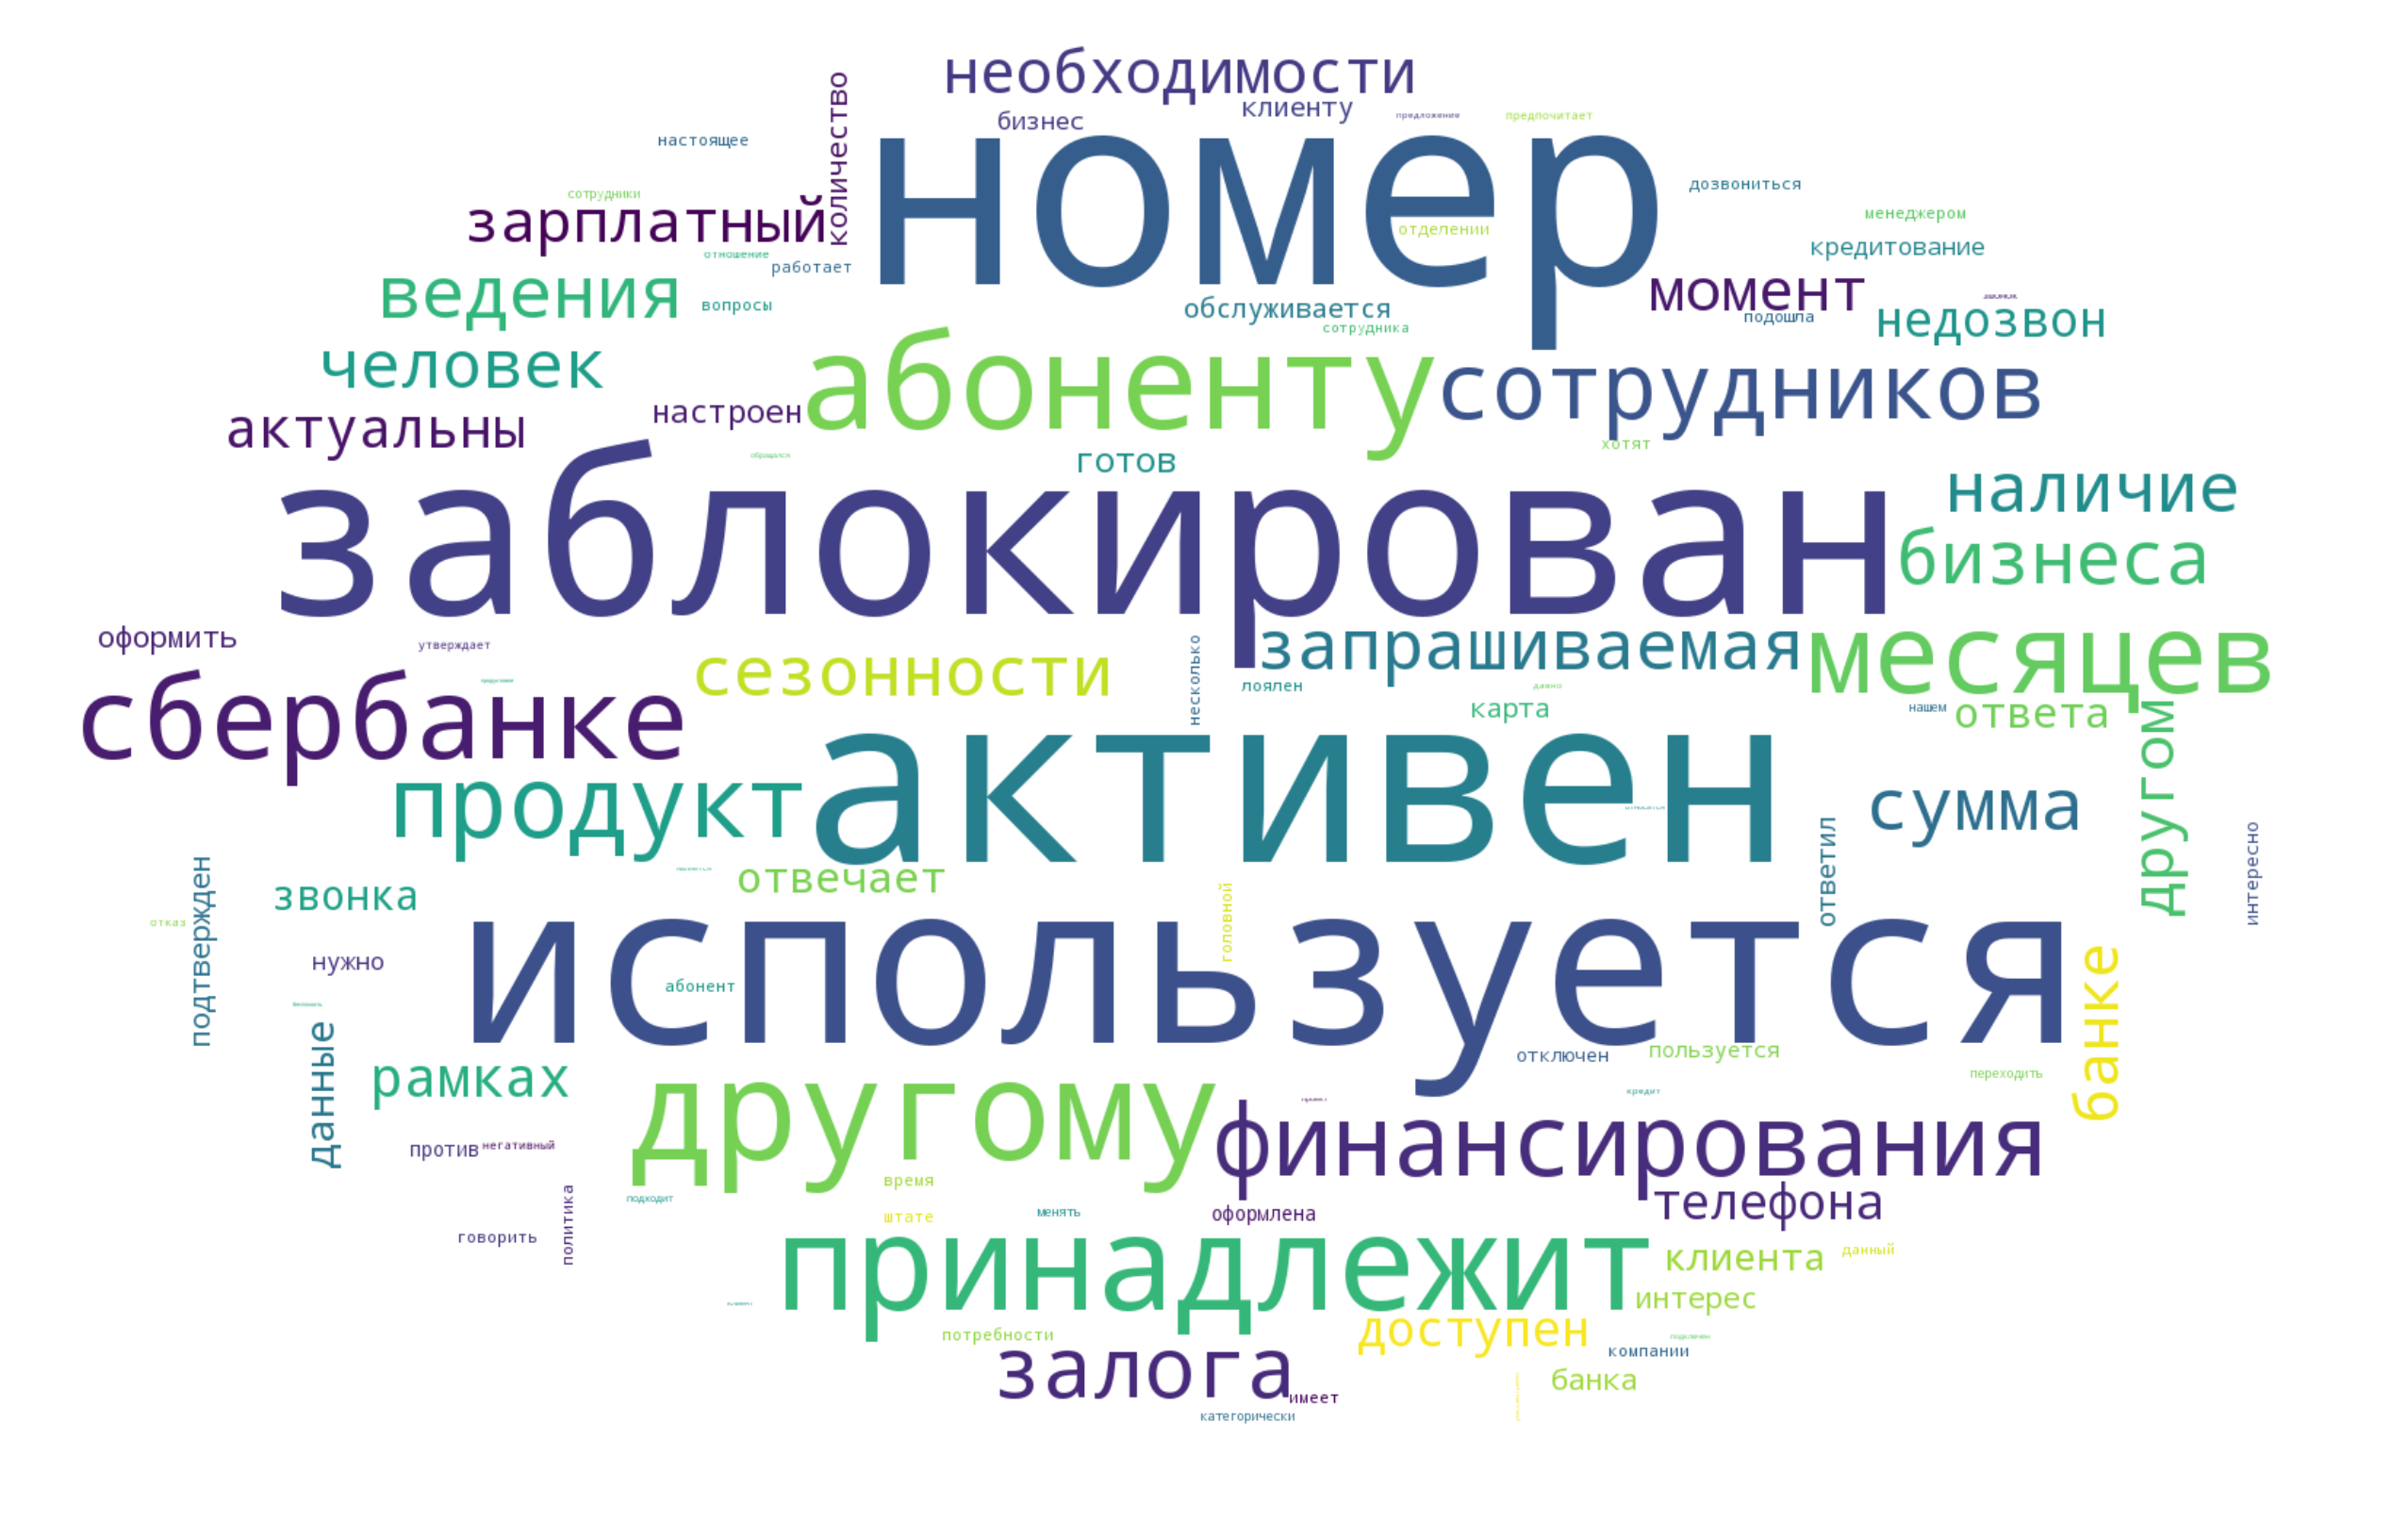

{'green': ['встреча', 'звонок', 'переговоры', 'приглашение в банк', 'клиент придет', 'придет в банк', 'выполнено', 'подключен', 'встреча была', 'рассчитан овердрафт', 'сделка', 'надежда есть', 'др продукт сб', 'клиент согласен на', 'думает', 'пока', 'интересует', 'возможно кредит', 'нужен продукт', 'кредитование интересно'], 'grey': ['не отработана. перенесена', 'нет контактов', 'не ответили', 'нет на месте', 'занято', 'счет есть сб', 'не соответсвует требованиям', 'км', 'счет есть', 'счет закрыт', 'есть кредит', 'дубль', 'погашен', 'казн. + бюджет', 'ошибка выборки', 'сегмент'], 'red': ['не нужен\\не может\\не хочет', 'отказ', 'др банк', 'дорогие тарифы', 'не лоялен ', 'обратится сам', 'отказ категорический', 'не разговаривают', 'территориально', 'условия', 'планируют закрывать счет', 'отказ от реструктуризации', 'много документов', 'не ведет деятельность', 'ликвидация', 'проблемы', 'черная зона', 'реорганизация', 'банкротство', 'реструктуризация', 'просрочка', 'небольшие обороты', 'г

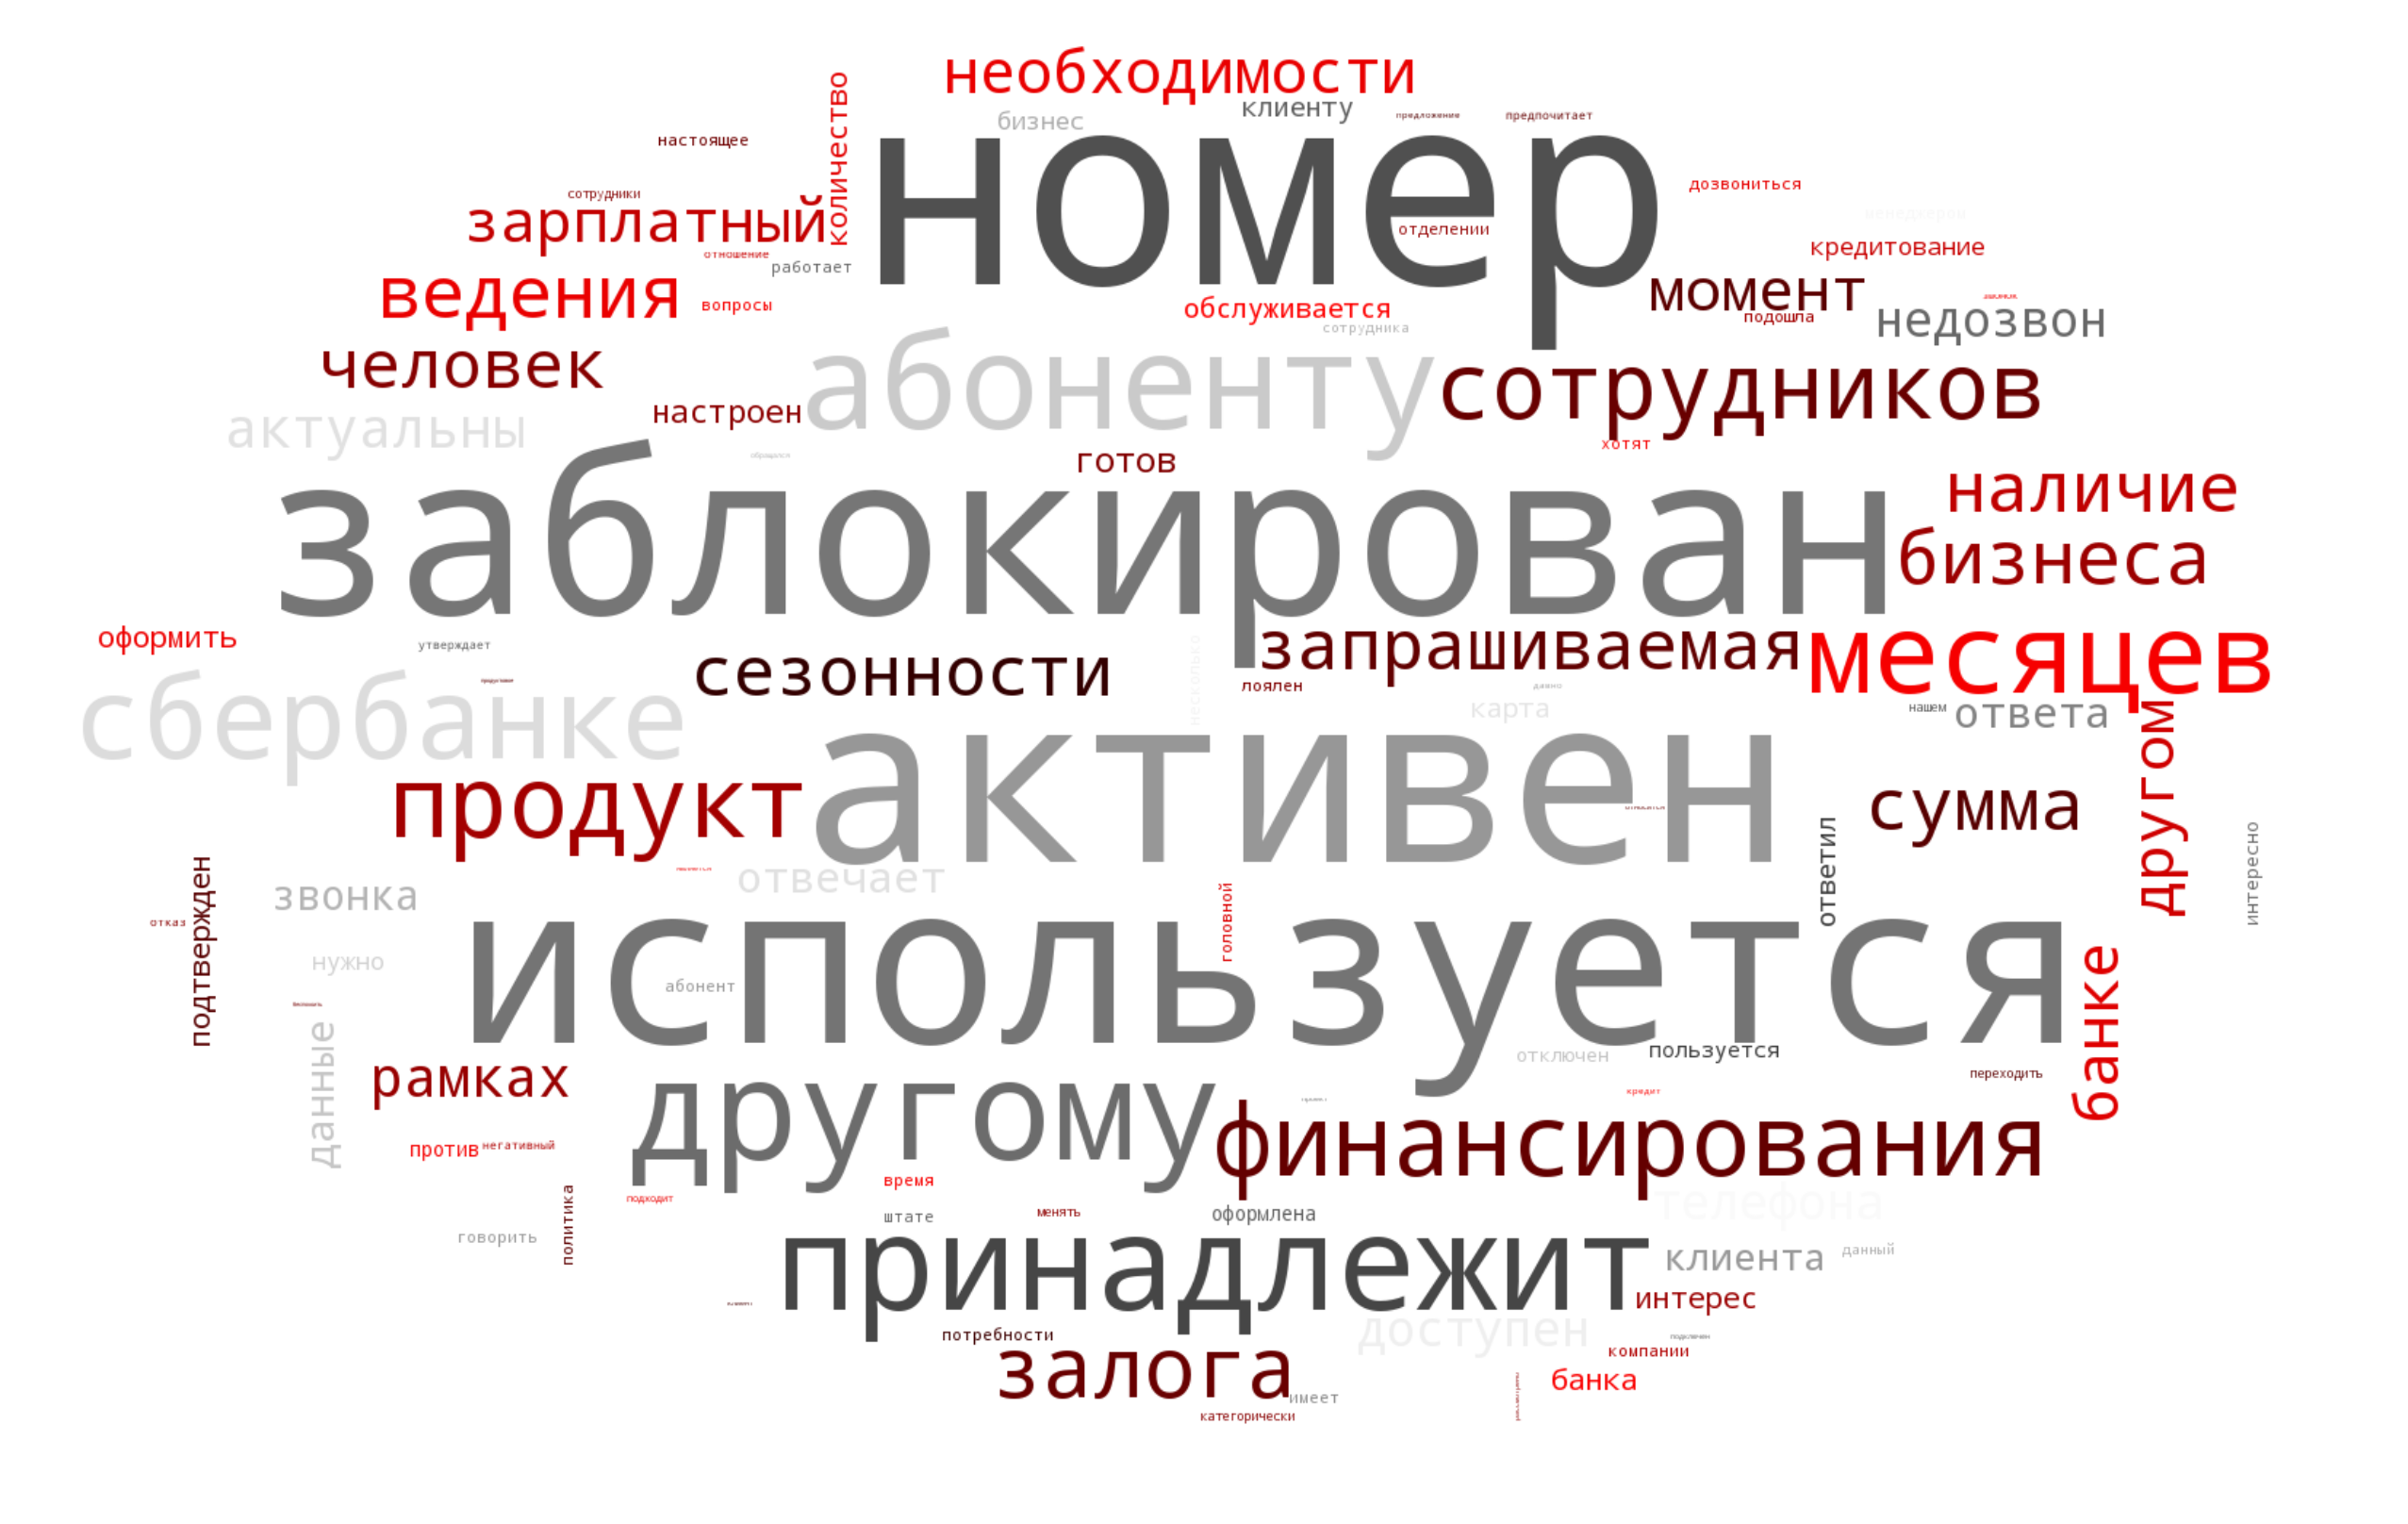

In [172]:
all_words={}
for lst in list(group_words.values()):
    all_words.update(lst)

cloud=get_cloud(200, all_words, 'all', 1)

class_colors=get_color_big_class()
colored_words={}
keys=list(group_words.keys())
for key in keys:
    if key=='мусор':
        continue
    if class_colors[key] in colored_words:
        colored_words[class_colors[key]]= colored_words[class_colors[key]]+list(group_words[key])
    else:
        colored_words[class_colors[key]]=list(group_words[key])

        default_color='grey'
grouped_color_func = GroupedColorFunc(colored_words, default_color)
cloud.recolor(color_func=grouped_color_func)
fig=plt.figure(figsize=(45,30))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fig.savefig(campaign+'\\clouds\\all_colored.png') 

In [170]:
colored_words

{'grey': ['абонент',
  'банка',
  'говорить',
  'доступен',
  'другое',
  'звонка',
  'интересно',
  'клиент',
  'комментарии',
  'менеджером',
  'несколько',
  'нужно',
  'ответил',
  'отключен',
  'подходит',
  'предложение',
  'продукт',
  'работает',
  'рассмотрено',
  'сотрудника',
  'телефону',
  'штате',
  'абоненту',
  'активен',
  'актуальны',
  'данные',
  'доступен',
  'другому',
  'заблокирован',
  'используется',
  'клиенту',
  'комментарии',
  'недозвон',
  'номер',
  'организации',
  'ответа',
  'отвечает',
  'предложение',
  'принадлежит',
  'продуктовое',
  'рассмотрено',
  'телефона',
  'бизнес',
  'давно',
  'данный',
  'имеет',
  'карта',
  'клиента',
  'кредит',
  'нашем',
  'негативный',
  'обращался',
  'оформлена',
  'подключен',
  'подходит',
  'пользуется',
  'предложение',
  'продукт',
  'проект',
  'рассмотрено',
  'сбербанке',
  'утверждает'],
 'red': ['больше',
  'время',
  'другое',
  'звонок',
  'категорически',
  'клиент',
  'комментарии',
  'лоялен',
 

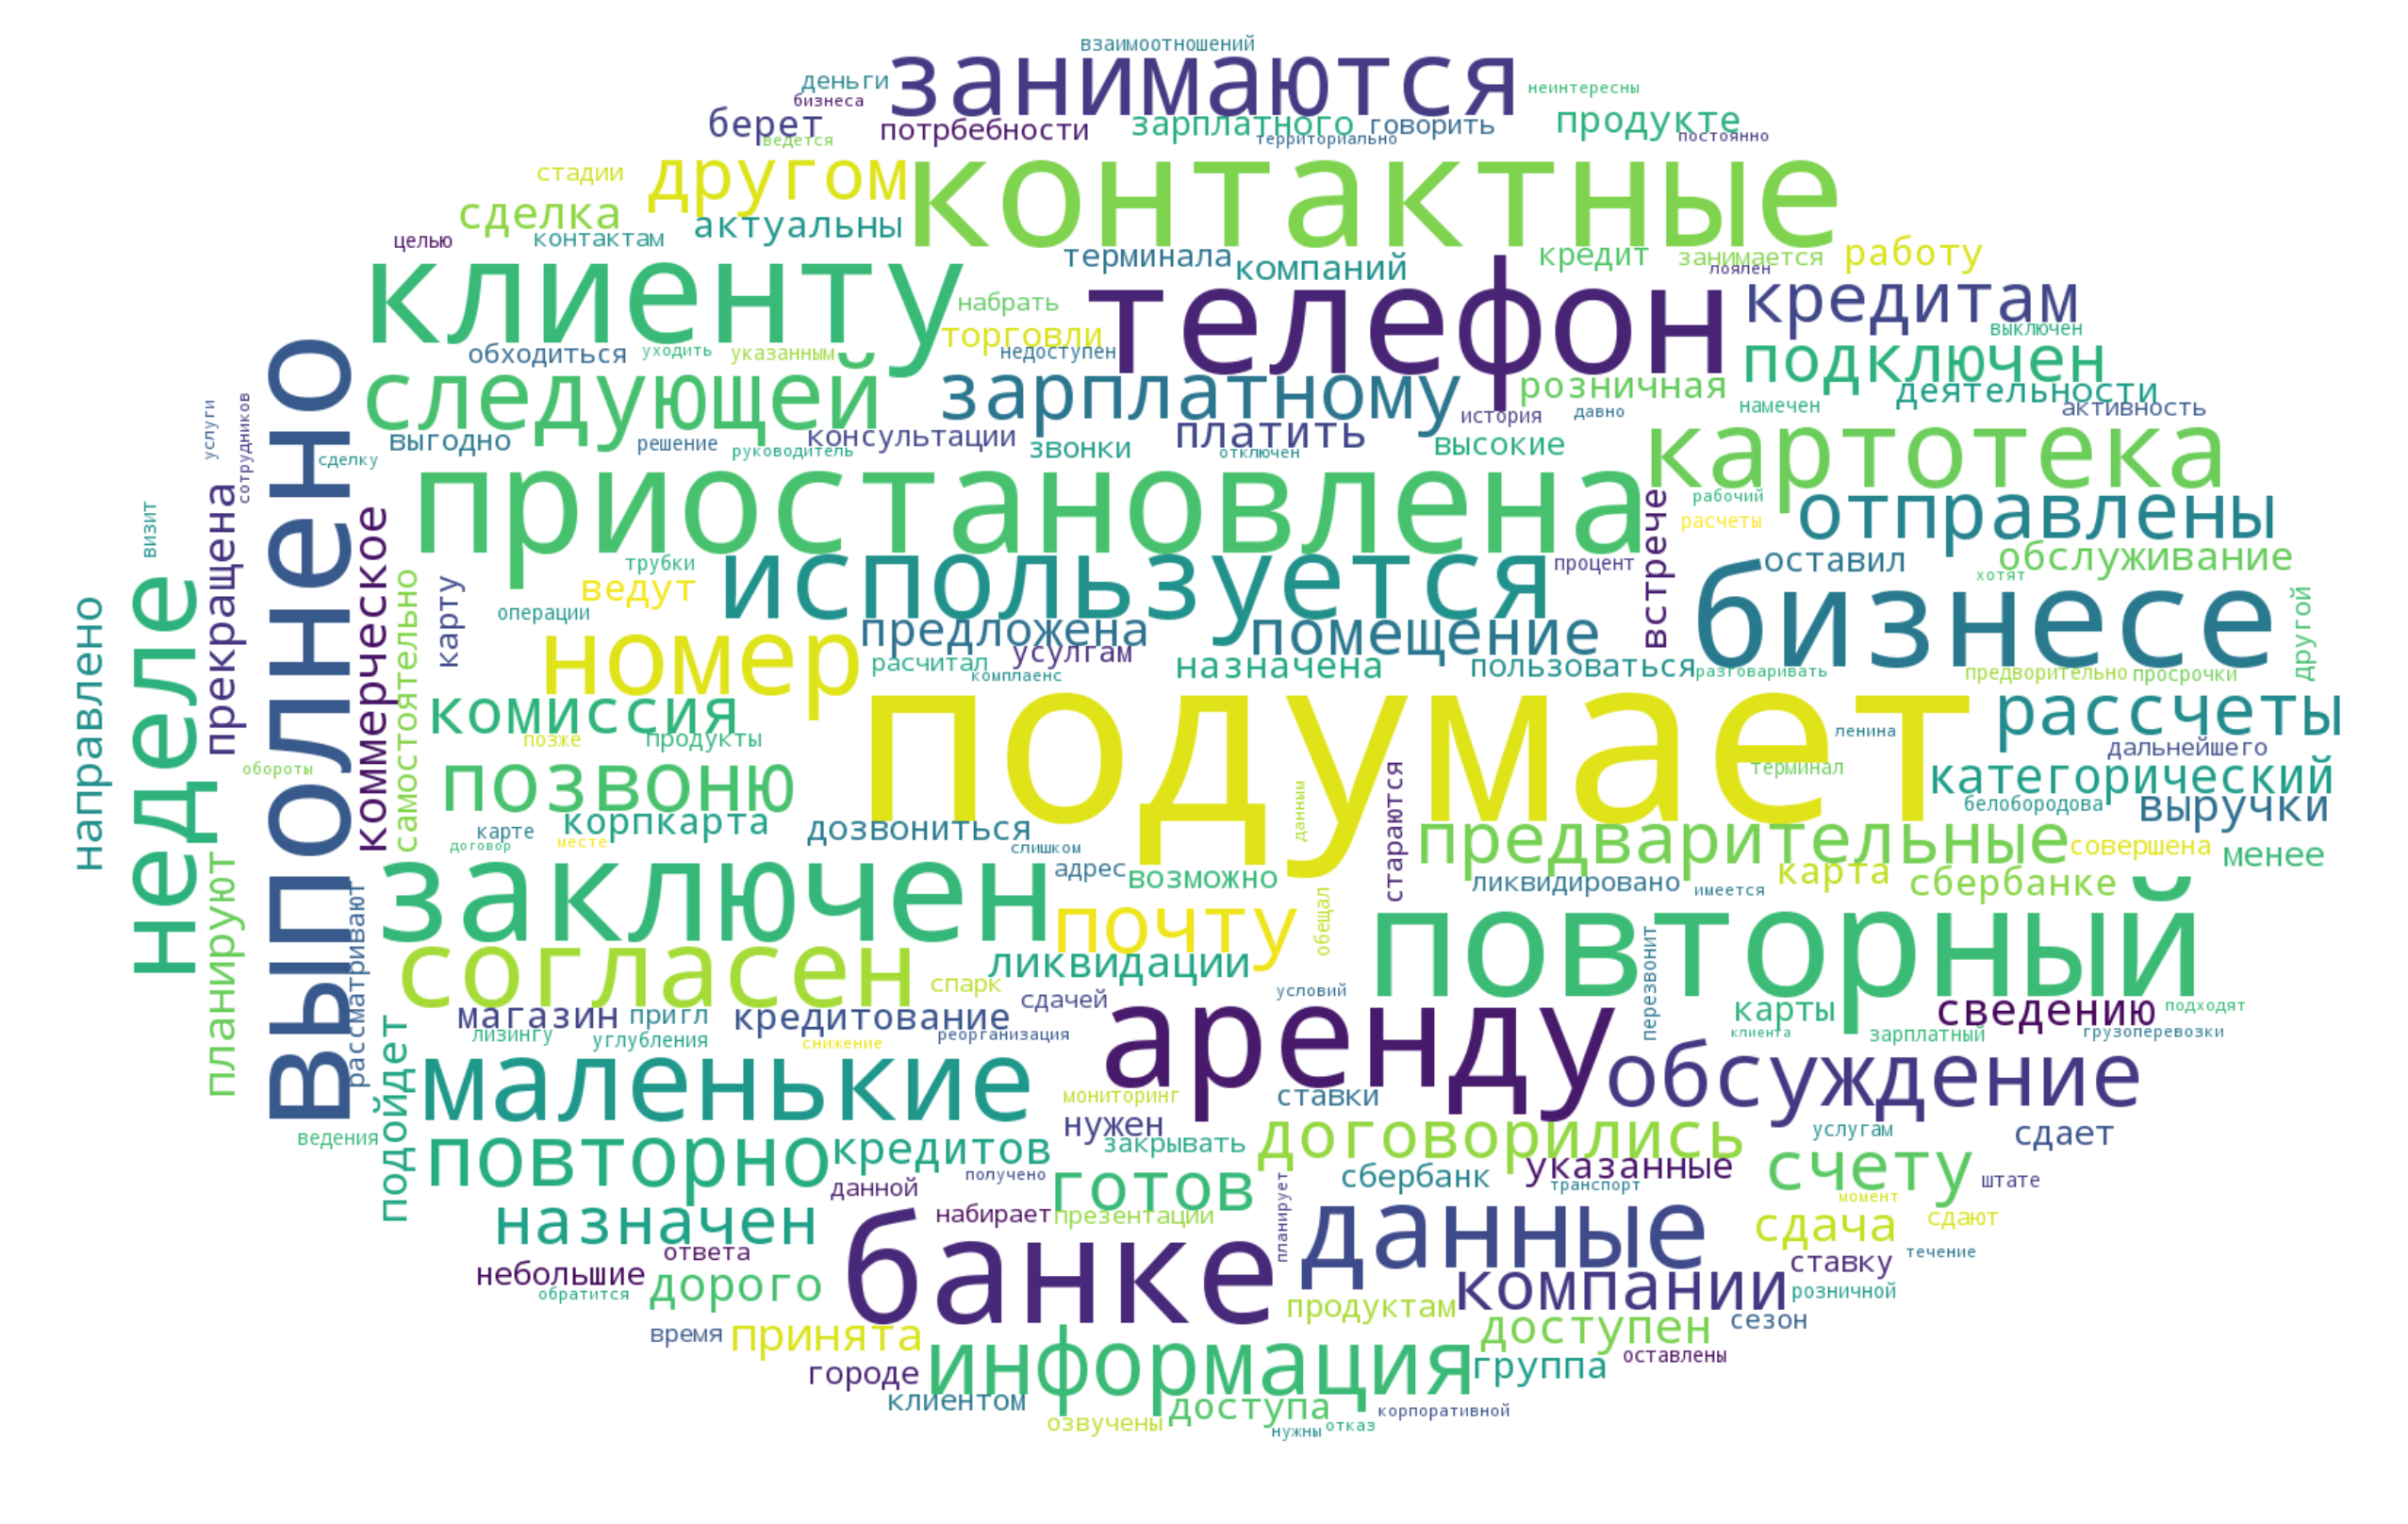

{'green': ['встреча', 'звонок', 'переговоры', 'приглашение в банк', 'клиент придет', 'придет в банк', 'выполнено', 'подключен', 'встреча была', 'рассчитан овердрафт', 'сделка', 'надежда есть', 'др продукт сб', 'клиент согласен на', 'думает', 'пока', 'интересует', 'возможно кредит', 'нужен продукт', 'кредитование интересно'], 'red': ['не отработана. перенесена', 'нет контактов', 'не ответили', 'нет на месте', 'занято', 'не нужен\\не может\\не хочет', 'отказ', 'др банк', 'дорогие тарифы', 'не лоялен ', 'обратится сам', 'отказ категорический', 'не разговаривают', 'территориально', 'условия', 'планируют закрывать счет', 'отказ от реструктуризации', 'много документов', 'не ведет деятельность', 'ликвидация', 'проблемы', 'черная зона', 'реорганизация', 'банкротство', 'реструктуризация', 'просрочка', 'небольшие обороты', 'группа компаний', 'документы', 'безналичный', 'оптовая торговля', 'голов. комп', 'аренда', 'сезонный бизнес', 'род деятельности', 'не рассчитывается', 'досрочное гашение', 'в

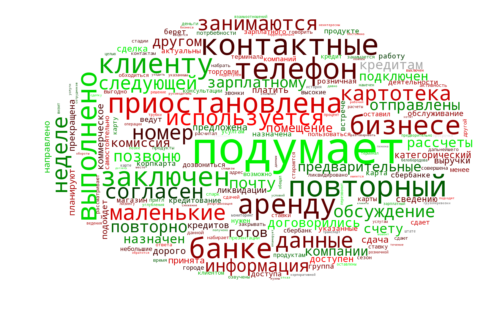

In [158]:
all_words={}
for lst in list(group_words.values()):
    all_words.update(lst)

fig, cloud=get_cloud(200, all_words, 'all', 1)

class_colors=get_color_big_class()
colored_words={}
keys=list(group_words.keys())
for key in keys:
    if key=='мусор':
        continue
    if class_colors[key] in colored_words:
        colored_words[class_colors[key]]= colored_words[class_colors[key]]+list(group_words[key])
    else:
        colored_words[class_colors[key]]=list(group_words[key])

        default_color='grey'
grouped_color_func = GroupedColorFunc(colored_words, default_color)
cloud.recolor(color_func=grouped_color_func)
plt.figure()
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

fig.savefig('colored_all'+'.png')

In [ ]:
from difflib import SequenceMatcher

vectorizer=CountVectorizer(min_df=0, max_features=30)

counts = vectorizer.fit_transform(data_split['TEXT']).toarray().sum(axis=0)                                               
words = vectorizer.get_feature_names()

words_freq={}
for word, count in zip(words, counts):
    words_freq[word]=count
keys=list(words_freq.keys())
for word in keys:
#     word=str(word)
    SequenceMatcher(lambda x:x == " ", word, simvol_sentences['C_12'][i])
    stemmed_word=stemmer.stem(word) 
    if stemmed_word in words_freq.keys():
        words_freq[stemmed_word]+=words_freq[word]
    else:
        words_freq[stemmed_word]=words_freq[word]
    words_freq.pop(word)



In [9]:
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


color_to_words = {
    # words below will be colored with a green single color function
    '#00ff00': ['beautiful', 'explicit', 'simple', 'sparse',
                'readability', 'rules', 'practicality',
                'explicitly', 'one', 'now', 'easy', 'obvious', 'better'],
    # will be colored with a red single color function
    'red': ['ugly', 'implicit', 'complex', 'complicated', 'nested',
            'dense', 'special', 'errors', 'silently', 'ambiguity',
            'guess', 'hard']
}

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Create a color function with single tone
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

# Plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [65]:
import nltk
tokens=[word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]